# IMDB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
torch.cuda.set_device(0)

In [4]:
from fastai.metrics import accuracy , MatthewsCorreff
#import langdetect

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.metrics import accuracy_thresh
from fastai.basic_data import *
from torch.utils.data import DataLoader, Dataset
from torch import nn
from fastai.basic_train import Learner
from torch import optim
import re
from IPython.core.debugger import set_trace
import pickle
import matplotlib.pyplot as plt
from os.path import isfile
from sklearn.metrics  import *

In [6]:
@dataclass
class MCC(Callback):       

    "Computes the confusion matrix."

    def on_train_begin(self, **kwargs):
        self.n_classes = 0

    def on_epoch_begin(self, **kwargs):
        self.cm = None
        
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        preds = last_output.argmax(-1).view(-1).cpu()
        targs = last_target.cpu()
        if self.n_classes == 0:
            self.n_classes = last_output.shape[-1]
            self.x = torch.arange(0, self.n_classes)
        cm = ((preds==self.x[:, None]) & (targs==self.x[:, None, None])).sum(dim=2, dtype=torch.float32)
        if self.cm is None: self.cm =  cm
        else:               self.cm += cm
        
    def on_epoch_end(self, **kwargs):
        #self.metric = self.cm        

        t_sum = self.cm.sum(dim=1)
        p_sum = self.cm.sum(dim=0)
        n_correct = torch.trace(self.cm)
        n_samples = p_sum.sum()
        cov_ytyp = n_correct * n_samples - torch.dot(t_sum, p_sum)
        cov_ypyp = n_samples ** 2 - torch.dot(p_sum, p_sum)
        cov_ytyt = n_samples ** 2 - torch.dot(t_sum, t_sum)
        self.metric = cov_ytyp / torch.sqrt(cov_ytyt * cov_ypyp)

## Preparing the data

We got the reviews about different companies products. The data has been scrapped form trust pilot , with columns such  as author, crawled , text , country , section_title ,  site_full,site_section , title .
         
The review is mentioned in column- 'Text'  . We are making a Language model and Classifier using This single column. We have also tried a tree based model using all categorical , numerical and TF-IDF vectorisation on 'text'. But Language Model + Classifier is performing far better in terms of MCC metric (metric used in the competition).

In [7]:
train_df = pd.read_csv('/home/FRACTAL/jitesh.arora/course-v3/nbs/dl1/data/reviews_hc2/hackathon2/train_df_final.csv')
#test_df = pd.read_csv('/home/FRACTAL/jitesh.arora/course-v3/nbs/dl1/data/reviews_hc2/hackathon2/test_df_final.csv')
test_df = pd.read_csv('/home/FRACTAL/jitesh.arora/course-v3/nbs/dl1/data/reviews_hc2/hackathon2/translated_test_correct.csv')

/home/FRACTAL/jitesh.arora/anaconda3/envs/fastainew/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (14,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
"""
Training data consist of 87% english language and rest are some european language. we have processed the data and translated 
these languages to english.
"""

def copy_text(row):
    if (row['lang_det']=='fr') | (row['lang_det']=='it'):
        return row['trans_text']
    else: 
        return row['text']
    
train_df['final_text'] = train_df.apply(lambda x: copy_text(x) , axis = 1)
test_df['final_text'] = test_df['text'].copy()




In [9]:
"""
We have created set of ids to be used as validation set based upon stratified sampling, and using that into the split
data into training and validation set.
"""


valid_df2 = train_df[train_df['is_valid']==1]
print(valid_df2.shape)

train_df2 = train_df[train_df['is_valid']==0]
print(train_df2.shape)

(12973, 21)
(116753, 21)


In [10]:
valid_df2.reset_index(inplace=True , drop=True)  

In [11]:
train_df2 =train_df2[['final_text' , 'target' , 'is_valid']]
valid_df2 =valid_df2[['final_text' , 'target' , 'is_valid']]
test_df = test_df[['final_text' , 'uuid' ]]

In [12]:
print(train_df2.shape)
print(test_df.shape)
print(valid_df2.shape)

(116753, 3)
(3645, 2)
(12973, 3)


In [13]:
path = '/home/FRACTAL/jitesh.arora/course-v3/nbs/dl1/data/reviews_hc2/hackathon2'

# Language Model 

Transfer learning of the model from intial model trained on Wikipedia text.

In [14]:
bs=32

In [15]:
data_lm =  (TextList.from_df(pd.concat([train_df2 , valid_df2 , test_df] , axis = 0),  path, cols='final_text')
                .random_split_by_pct(0.1, seed = 42)
                .label_for_lm()  #label_from_df(cols=1)
                .databunch())

In [16]:
data_lm.save('tmp_lm_all_translated')

In [17]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm_all_translated', bs=bs)

In [19]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


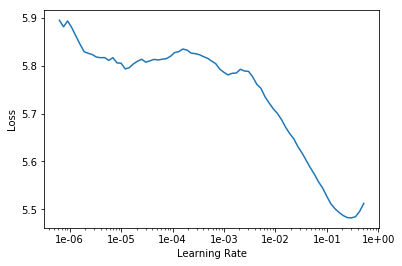

In [20]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [21]:
learn.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.114931,3.965983,0.272159
2,4.020288,3.900206,0.278117


In [62]:
learn.save('lm_trans_head')
learn.load('lm_trans_head');
learn.unfreeze()
learn.fit_one_cycle(8, 3e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.766985,3.664431,0.304596
2,3.601502,3.534194,0.314368
3,3.476046,3.455423,0.322275
4,3.346060,3.408303,0.326534
5,3.205208,3.388299,0.329869
6,3.056303,3.383706,0.331845
7,2.915291,3.399394,0.330520
8,2.832769,3.411110,0.330033


In [63]:
learn.save('lm_trans_unfz')
learn.load('lm_trans_unfz');

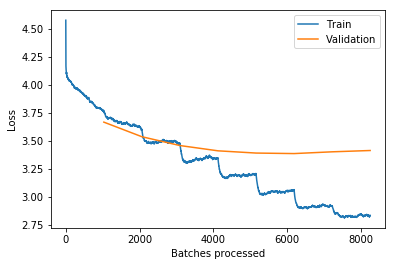

In [64]:
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy
1,2.644132,3.276555,0.352474
2,2.831712,3.310848,0.345571
3,3.069699,3.386002,0.332619
4,3.267944,3.446904,0.323748
5,3.302282,3.458067,0.322241
6,3.266251,3.457608,0.323322
7,3.209138,3.415605,0.328230
8,3.109571,3.388931,0.332155
9,3.045651,3.350946,0.338063
10,2.855296,3.307249,0.346065


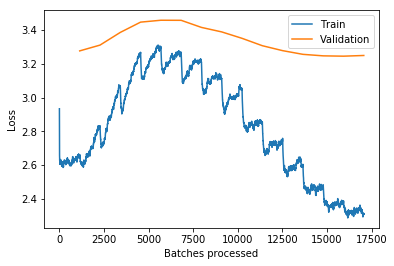

In [25]:
learn.fit_one_cycle(15, 1e-2, moms=(0.8,0.7))
learn.recorder.plot_losses()

In [65]:
learn.save('lm_trans_unfz_v2')
learn.save_encoder('fine_tuned_all_tuned');

In [66]:
learn.load('lm_trans_unfz_v2');

In [67]:
TEXT = "i liked this because"
N_WORDS = 40
N_SENTENCES = 2

In [55]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i liked this because netflix minimums amaze ascot reach expo .our ned eyewear uneducated -5 absurd riley yards mdi fantasy 70s enjoyment store heraklion thanked posting scrubs boy completes iran abricot begging ibrahim agra decesion andy firearms protective concrete msr india eve pennies blend
i liked this because doubt omitted adrian sony headed rushed aiming song joining extraordinary imaginable 15.95 x5 van hit bolt glitches pickpockets severe castelli downward paperback 16.03.17 helps recognition reputed rick pairs & cad$ comparetravelinsurance.com.au ankle graduation halpenny doggy 99.9 👍 sitting dd cedric


## Classifier

We will use the Language model to classify the reviews into positive and negative sentiments.

In [75]:
data_cls = TextClasDataBunch.from_df(path , train_df2 , valid_df2 , test_df , bs = 64 , max_vocab =60000 , min_freq=2 
                                    
                                    , vocab = data_lm.train_ds.vocab , text_cols = 'final_text' , label_cols='target'
                                    )

In [76]:
print(len(data_cls.train_ds))
print(len(data_cls.valid_ds))
print(len(data_cls.test_ds))

print('vocab size' ,len(data_cls.vocab.itos))

116753
12973
3645
vocab size 20499


In [24]:
#data_cls.save('tmp_clas_trans')
data_cls = TextClasDataBunch.load(path, 'tmp_clas_trans', bs=64)

In [25]:
data_cls.show_batch(2)

text,target
"xxbos xxmaj cuba xxmaj xxunk \n xxmaj january 15 - 22 , 2017 \n xxmaj day 1 \n xxmaj consider xxmaj cuba : it is a chunk of the xxmaj north xxmaj american xxmaj continent which xxunk 90 miles to the southeast during the third phase of the xxunk of the super - continent xxmaj xxunk 50 million years ago . xxmaj the xxmaj island of xxmaj cuba is",1
"xxbos i 've recently started a small business doing pet photography . i used a few other sites to design business cards , and had one set printed by a lesser company . xxmaj those "" other "" cards are cheap , flimsy , pixelated , and easily show wear at the cut edges . xxmaj they arrived in a large cardboard box stuffed with shipping paper to keep the",1


We can then create a model to classify those reviews and load the encoder we saved before.

In [26]:
learn = text_classifier_learner(data_cls, drop_mult=0.5)  
learn.load_encoder('fine_tuned_all_tuned')
learn.metrics = [accuracy , MCC()]

In [27]:
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


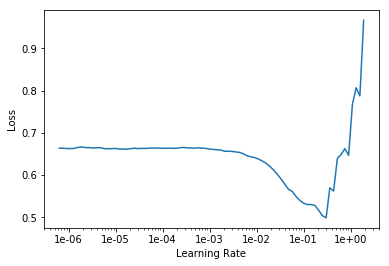

In [81]:
learn.lr_find()
learn.recorder.plot()

In [82]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,mcc
1,0.090198,0.098140,0.967625,0.639498
2,0.099998,0.096449,0.969783,0.695337
3,0.097286,0.077477,0.972867,0.711221
4,0.083102,0.070268,0.974023,0.723162
5,0.077025,0.066732,0.976413,0.753307


In [83]:
learn.save('trans_1');
learn.load('trans_1');

In [84]:
learn.freeze_to(-2)
learn.fit_one_cycle(10, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,mcc
1,0.076205,0.059321,0.980113,0.799369
2,0.081756,0.054176,0.982040,0.817704
3,0.074560,0.053092,0.982502,0.823134
4,0.070158,0.064354,0.978879,0.780257
5,0.060752,0.049156,0.984429,0.845568
6,0.065255,0.054608,0.984429,0.843937
7,0.051002,0.050088,0.985123,0.852397
8,0.047354,0.055800,0.984660,0.847092
9,0.046256,0.055217,0.984660,0.847296
10,0.028688,0.057347,0.984815,0.849976


In [85]:
learn.save('trans_2');
learn.load('trans_2');

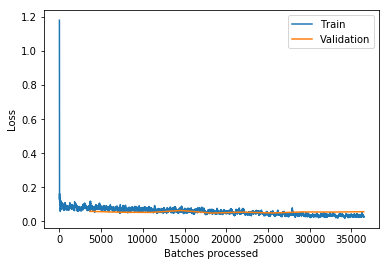

In [86]:
learn.recorder.plot_losses()

In [87]:
learn.load('trans_2')
learn.freeze_to(-3)
learn.fit_one_cycle(5, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

learn.save('trans_3');
learn.load('trans_3');

epoch,train_loss,valid_loss,accuracy,mcc
1,0.039750,0.060781,0.983196,0.836232
2,0.105666,0.067256,0.977569,0.769315
3,0.066900,0.056476,0.982965,0.828350
4,0.062705,0.050871,0.983967,0.841425
5,0.057187,0.051132,0.983735,0.838387


In [88]:
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,mcc
1,0.061092,0.050874,0.983890,0.839238
2,0.081032,0.051763,0.983967,0.841034
3,0.060299,0.054331,0.984121,0.843927
4,0.052114,0.052729,0.984198,0.844341
5,0.072238,0.052922,0.983890,0.839466
6,0.060151,0.051621,0.984275,0.844773


In [28]:
#learn.save('trans_4')
learn.load('trans_4');

In [25]:
learn.load('trans_2');
learn.fit_one_cycle(3, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,mcc
1,0.031377,0.062242,0.985431,0.856037
2,0.022589,0.061478,0.985740,0.859233
3,0.028648,0.061902,0.985663,0.857519


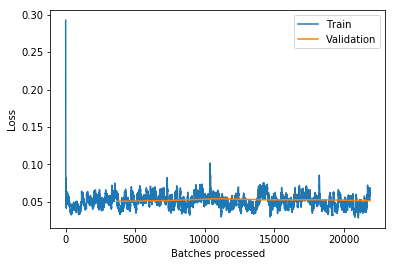

In [89]:
learn.recorder.plot_losses()

In [54]:
from sklearn.metrics import confusion_matrix , matthews_corrcoef
learn.load('trans_2')
val_preds , val_targs = learn.get_preds()

In [55]:
val_preds = val_preds[:,1]
print(val_preds.shape)

torch.Size([12973])


In [56]:
val_preds = val_preds.numpy()
val_targs = val_targs.numpy()

In [57]:
%%time
res = []
ps = np.linspace(0.5, 1, 50)
for p in ps:
    val_res  = np.where(val_preds>=p  ,1 ,0)
    mcc = matthews_corrcoef(val_targs , val_res)

    res.append(mcc)

CPU times: user 716 ms, sys: 0 ns, total: 716 ms
Wall time: 715 ms


In [58]:
print( 'best mcc', max(res))
ps[np.argmax(res)]

best mcc 0.8567065340753451


0.7346938775510203

In [60]:
best_p =  ps[np.argmax(res)]
val_res  = np.where(val_preds>=best_p,1 ,0)

print('Confusion Matrix\n' , confusion_matrix(val_targs , val_res))
print( 'MCC score ', matthews_corrcoef(val_targs , val_res))

Confusion Matrix
 [[  619   107]
 [   87 12160]]
MCC score  0.8567065340753451


In [110]:
"""
Predict the results for test data.
"""
test_preds ,_ = learn.get_preds(DatasetType.Test)
print(test_preds.shape)

test_preds = test_preds[:, 1]
print(test_preds.shape)

torch.Size([3645, 2])
torch.Size([3645])


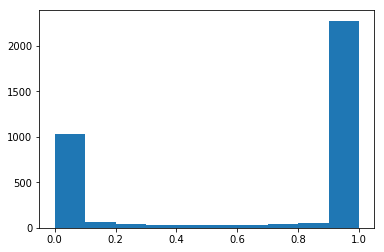

In [111]:
"""
Look at the distribution on the reviews of probabilities for positive class
"""
plt.hist(test_preds.numpy());

In [112]:
test_new = pd.read_csv('/home/FRACTAL/jitesh.arora/course-v3/nbs/dl1/data/reviews_hc2/hackathon2/test_FN.csv')


In [116]:
submission_file = pd.DataFrame({'tsfm_text': [path for path in data_cls.test_ds.x]})
submission_file['score']  = test_preds.numpy()
submission_file['text'] = test_df['final_text'].copy()
submission_file['uuid'] = test_df['uuid'].copy()

In [117]:
submission_file['Prediction']  = submission_file['score'].apply(lambda x:'positive' if  x>=best_p else 'negative' )

In [118]:
test_new.head(2)

,Filename,uuid
0,0010e1c711e659b49024ede29074848a.json,dbf39c8ac808f1e4cf242a2644c760e8e6bc480e
1,0014574e5a63fdeb277865902a7acfb3.json,2702575fc6d0f3a7d6665f872db8150016fa144d


In [121]:
output_v2 = submission_file.merge(test_new , on = ['uuid'])

In [123]:
output_v2 = output_v2[['Prediction' , 'Filename']]

In [125]:
output_v2.to_csv('/home/FRACTAL/jitesh.arora/course-v3/nbs/dl1/output_v2.csv' , index = False)

In [46]:
submission_file.to_csv('preds_test_new_LM_stratified_MCC_865.csv' , index = False)